## ⚙️ Import Libraries

In [1]:
#IMPORT LIBRARIES

# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec
from sklearn.utils.class_weight import compute_class_weight

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


## ⏳ Load the Data

In [2]:
data = np.load('/kaggle/input/last-try/mars_for_students.npz')

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

x_test_ev = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {x_test_ev.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [3]:
category_map = {0: 0, # background
           1: 1,  # soil
           2: 2,  # bedrock
           3: 3,  # sand
           4: 4  # big rock
}

In [4]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [5]:
def display_color_mapped_image_continuous(image, n_colors=5):
    """
    Display an image with colors mapped from a given image array using a continuous colormap.
    The image array should contain integer values from 0 to n_colors-1, where each integer
    represents a different color sampled linearly from the colormap.

    Args:
    image (ndarray): An array of shape (H, W) containing integer values from 0 to n_colors-1.
    n_colors (int): The number of colors to use from the colormap. Max 5.
    """
    if n_colors > 5:
        raise ValueError("Maximum number of colors is 5.")
    if not (0 <= image.min() and image.max() < n_colors):
        raise ValueError("Image values should be in the range [0, n_colors-1].")

    # Using a continuous colormap (like 'viridis') and sampling linearly
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, n_colors))

    # Map the colors
    colored_image = colors[image.astype(int)]

    return colored_image

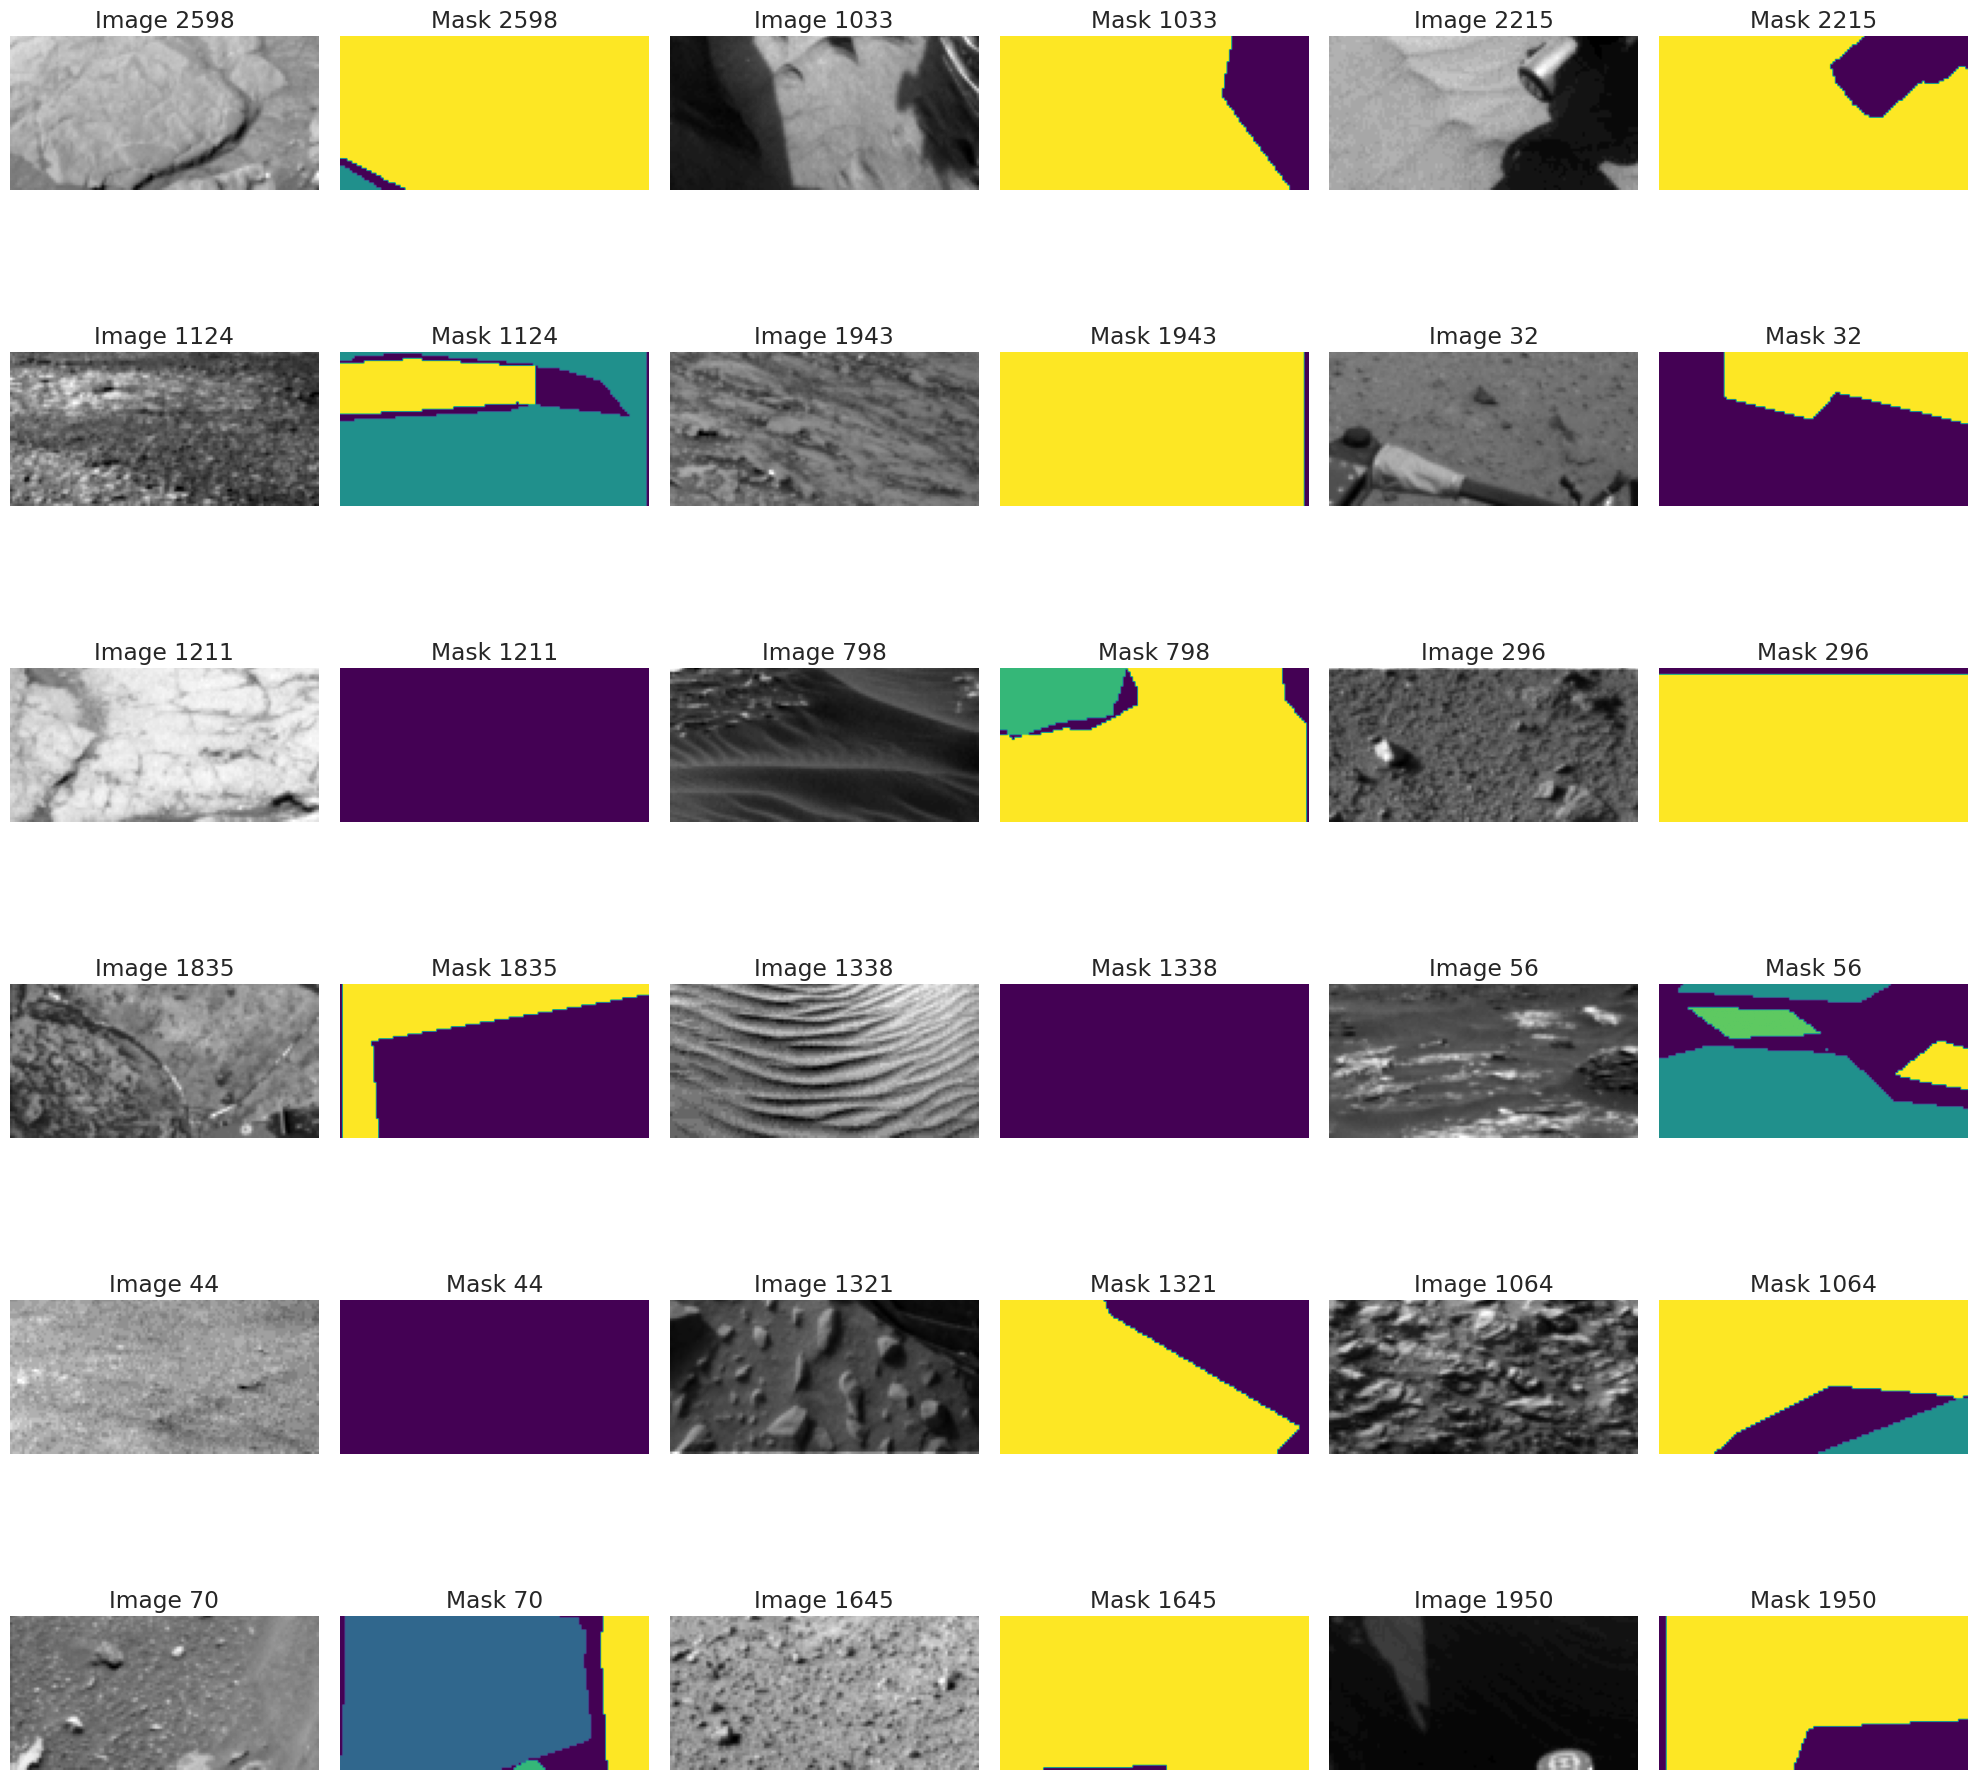

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot random images and their masks
def plot_random_images_with_masks(X_train, y_train, num_pairs=18):
    # Randomly select indices for the images and masks
    indices = np.random.choice(len(X_train), size=num_pairs, replace=False)

    # Create a grid layout for displaying images and masks
    plt.figure(figsize=(20, 20))  # Adjust size for better visibility

    for i, idx in enumerate(indices):
        # Display the grayscale Mars terrain image
        plt.subplot(6, 6, 2 * i + 1)  # Odd columns for images
        plt.imshow(X_train[idx], cmap='gray')
        plt.title(f"Image {idx}")
        plt.axis("off")

        # Display the segmentation mask
        plt.subplot(6, 6, 2 * i + 2)  # Even columns for masks
        plt.imshow(y_train[idx], cmap='viridis')  # Use a colormap to distinguish classes
        plt.title(f"Mask {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Plot 25 random pairs of images and masks
plot_random_images_with_masks(X_train, y_train, num_pairs=18)

In [7]:
# Index of the type of image to remove
ET_index= 1082
ET_mask = y_train[ET_index]
count = 0

# Searching of the outsider
ET_to_remove = []

for i in range(len(y_train)):
    if np.array_equal(y_train[i], ET_mask):
        ET_to_remove.append(i)
        count = count+1


# Remove Alien
X= np.delete(X_train, ET_to_remove, axis=0)
y= np.delete(y_train, ET_to_remove, axis=0)
count

110

In [8]:
# Split the data into training, validation, and test sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.2, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_validation, y_validation, test_size = 0.5, random_state=seed)

# Apply horizontal flip augmentation to the training set if specified
horizontal_flip = False

if horizontal_flip:
    X_train_flipped = np.flip(X_train, axis=2)
    X_train = np.concatenate([X_train, X_train_flipped], axis=0)
    y_train_flipped = np.flip(y_train, axis=2)
    y_train = np.concatenate([y_train, y_train_flipped], axis=0)

# Display the shapes of the resulting datasets
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2004, 64, 128),
 (2004, 64, 128),
 (250, 64, 128),
 (250, 64, 128),
 (251, 64, 128),
 (251, 64, 128))

In [9]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
test_set = X_test[..., np.newaxis] / 255.0

X_val = X_val[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [10]:
# Dictionary to store the count of images for each class
class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

# Loop through each class
for class_id in class_counts.keys():
    # Count the number of images where the class appears in at least 10 pixels
    class_counts[class_id] = np.sum(np.sum(y_train == class_id, axis=(1, 2)) >= 8)

# Print the results
for class_id, count in class_counts.items():
    print(f"Class {class_id}: present in {count} images (at least 8 pixels)")

Class 0: present in 1674 images (at least 8 pixels)
Class 1: present in 998 images (at least 8 pixels)
Class 2: present in 940 images (at least 8 pixels)
Class 3: present in 680 images (at least 8 pixels)
Class 4: present in 49 images (at least 8 pixels)


In [11]:
# Identify indexes of masks that contain at least 10 pixes of class 4th
class_4_indices = [i for i, label in enumerate(y_train) if tf.reduce_sum(tf.cast(label == 4, tf.int32)) >= 8]

# Extract the images and the masks associated with class 4
X_class_4 = X_train[class_4_indices]
y_class_4 = y_train[class_4_indices]

print(f"Samples with classe 4: {len(X_class_4)}")


Campioni con classe 4: 49


In [13]:
from tensorflow.keras.layers import RandomFlip, RandomTranslation, RandomZoom, RandomRotation

def augment_image4(image, label):
    # If necessary, adds a channel dimension
    if len(image.shape) == 2:
        image = tf.expand_dims(image, axis=-1)
    if len(label.shape) == 2:
        label = tf.expand_dims(label, axis=-1)

    # Concatenate image and label through the channel
    combined = tf.concat([image, label], axis=-1)  # Shape: (64, 128, 2)

    # AUGMENTATION PIPELINE

    # Casual flip
    random_flip = RandomFlip(mode="horizontal")
    combined = random_flip(combined)

    # Casual translation
    random_translation = RandomTranslation(
        height_factor=(-0.1,0.1),
        width_factor=(-0.1, 0.1),
        fill_mode="nearest",  # Riempie i pixel mancanti con il valore del pixel più vicino
        interpolation="bilinear"
    )
    combined = random_translation(combined)

    # Casual zoom
    random_zoom = RandomZoom(
        height_factor=(0.0, 0.1),
        width_factor=(0.0, 0.1),
        fill_mode="nearest",  # Riempie i pixel mancanti con il valore del pixel più vicino
        interpolation="bilinear"
    )
    combined = random_zoom(combined)

    # Casual rotation
    random_rotation = RandomRotation(factor=0.1,fill_mode="nearest", interpolation="bilinear")
    combined = random_rotation(combined)

    # Divides image and label
    image = combined[..., 0:1]  # Primo canale
    label = combined[..., 1:2]  # Secondo canale

    # Adjustments for image (brightness and contrast)
    delta = tf.random.uniform([], -0.1, 0.1)
    image = tf.image.adjust_brightness(image, delta)

    contrast_factor = tf.random.uniform([], 0.9, 1.1)
    image = tf.image.adjust_contrast(image, contrast_factor)

    # If previously added, removes channel dimension
    image = tf.squeeze(image, axis=-1)
    label = tf.squeeze(label, axis=-1)

    return image, label


In [14]:
def augment_class_4(X_class_4, y_class_4, target_factor=40):
    """
    Augment samples of class 4 until their number is increased by the target_factor.
    """
    augmented_X = []
    augmented_y = []

    num_original = len(X_class_4)
    total_target = num_original * target_factor

    # Calculate how many augmentations are needed
    current_total = num_original
    while current_total < total_target:
        for i in range(len(X_class_4)):
            img, mask = augment_image4(X_class_4[i], y_class_4[i])
            augmented_X.append(img)  # Non è più necessario `.numpy()`, già in formato TensorFlow
            augmented_y.append(mask)  # Non è più necessario `.numpy()`, già in formato TensorFlow
            current_total += 1
            if current_total >= total_target:
                break

    # Convert to NumPy arrays
    augmented_X = tf.stack(augmented_X).numpy()  # Usa `tf.stack` per raggruppare i tensori in un array
    augmented_y = tf.stack(augmented_y).numpy()  # Idem per le label

    # Ensure the augmented data has the correct shape
    if len(augmented_X.shape) == 3:  # Se manca il canale
        augmented_X = np.expand_dims(augmented_X, axis=-1)

    return augmented_X, augmented_y

# Apply targeted oversampling and augmentation to class 4
augmented_X_class_4, augmented_y_class_4 = augment_class_4(X_class_4, y_class_4, target_factor=32)


In [15]:
# Concatenate the new samples with the training set
X_train = np.concatenate([X_train, augmented_X_class_4], axis=0)
y_train = np.concatenate([y_train, augmented_y_class_4], axis=0)

print(f"New number of samples in the training set: {X_train.shape[0]}")

New number of samples in the training set: 3523


In [16]:
# Dictionary to store the count of images for each class
class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

# Loop through each class
for class_id in class_counts.keys():
    # Count the number of images where the class appears in at least 10 pixels
    class_counts[class_id] = np.sum(np.sum(y_train == class_id, axis=(1, 2)) >= 8)

# Result
for class_id, count in class_counts.items():
    print(f"Class {class_id}: present in {count} images (at least 8 pixels)")

Class 0: present in 3187 images (at least 8 pixels)
Class 1: present in 1496 images (at least 8 pixels)
Class 2: present in 1848 images (at least 8 pixels)
Class 3: present in 1688 images (at least 8 pixels)
Class 4: present in 1243 images (at least 8 pixels)


In [17]:
# Set batch size for training
batch_size = 128

# Set learning rate for the optimiser
learning_rate = 4e-4

# Set early stopping patience threshold
patience = 30

# Set maximum number of training epochs
epochs = 200


In [18]:
# Define the Residual block with configurable parameters
def residual_block(x, filters, kernel_size=3, padding='same',
                   activation='relu', stack=2, name='residual'):

    for s in range(stack):
        # Save input for skip connection
        skip = x

        # First convolutional block with Batch Normalisation and activation
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv1_{s}')(x)
        x = tfkl.GroupNormalization(name=f'{name}_bn1_{s}')(x)
        x = tfkl.Activation(activation, name=f'{name}_act1_{s}')(x)

        # Second convolutional block
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv2_{s}')(x)
        x = tfkl.GroupNormalization(name=f'{name}_bn2_{s}')(x)

        # Adjust skip connection dimension if needed
        if skip.shape[-1] != filters:
            skip = tfkl.Conv2D(filters, 1, padding=padding, name=f'{name}_proj_{s}')(skip)
            skip = tfkl.GroupNormalization(name=f'{name}_proj_bn_{s}')(skip)

        # Add skip connection and apply activation
        x = tfkl.Add(name=f'{name}_add_{s}')([x, skip])
        x = tfkl.Activation(activation, name=f'{name}_act2_{s}')(x)

    return x

In [19]:
def get_unet_model(input_shape=input_shape, num_classes=num_classes, seed=seed, name='UNet'):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    #ENCODER
    # First Downsampling
    conv1_1 = residual_block(x = input_layer,
                             filters = 64,
                             kernel_size = (2,2),
                             padding = 'same',
                             activation='relu',
                             stack=2,
                             name='conv1_1')
    pool1 = tfkl.MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    # Second Downsampling
    conv2_1 = residual_block(x = pool1,
                             filters = 128,
                             kernel_size = (2,2),
                             padding = 'same',
                             activation='relu',
                             stack=2,
                             name='conv2_1')
    pool2 = tfkl.MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = tfkl.Conv2DTranspose(64, (2,2), strides=(2,2), name='up12', padding='same')(conv2_1)
    conv1_2 = tfkl.Add(name = 'merge12')([up1_2, conv1_1])
    conv1_2 = residual_block(x = conv1_2,
                             filters = 64,
                             kernel_size = (2,2),
                             padding = 'same',
                             activation='relu',
                             stack=2,
                             name='conv1_2')

    # BOTTLENECK
    conv3_1 = residual_block(x = pool2,
                             filters = 256,
                             kernel_size = (2,2),
                             padding = 'same',
                             activation='relu',
                             stack=2,
                             name='conv3_1')
    
    # DECODER
    up2_2 = tfkl.Conv2DTranspose(128, (2,2), strides=(2,2), name='up22', padding='same')(conv3_1)
    conv2_2 = tfkl.Add(name = 'merge22')([up2_2, conv2_1])
    conv2_2 = residual_block(x = conv2_2,
                             filters = 128,
                             kernel_size = (2,2),
                             padding = 'same',
                             activation='relu',
                             stack=2,
                             name='conv2_2')
    
    up1_3 = tfkl.Conv2DTranspose(64, (2,2), strides=(2,2), name='up13', padding='same')(conv2_2)
    conv1_3 = tfkl.Add(name = 'merge13')([up1_3, conv1_1, conv1_2])
    conv1_3 = residual_block(x = conv1_3,
                             filters = 64,
                             kernel_size = (2,2),
                             padding = 'same',
                             activation='relu',
                             stack=2,
                             name='conv1_3')

    conv1_3 = tfkl.SpatialDropout2D(0.2, seed=seed, name='Dropout')(conv1_3)
    
    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=(1,1), padding='same', activation="softmax", name='output_layer')(conv1_3)

    model = tfk.Model(inputs=input_layer, outputs=output_layer)
    return model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_1_conv1_0   │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_1_bn1_0     │ (None, 64, 128, │       128 │ conv1_1_conv1… │   Y   │
│ (GroupNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_1_act1_0    │ (None, 64, 128, │         0 │ conv1_1_bn1_0… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_1_conv2_0   │ (None, 64, 128, │    16,448 │ conv1_1_act1_… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_1_proj_0    │ (None, 64, 128, │       128 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_1_bn2_0     │ (None, 64, 128, │       128 │ conv1_1_conv2… │   Y   │
│ (GroupNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_1_proj_bn_0 │ (None, 64, 128, │       128 │ conv1_1_proj_… │   Y   │
│ (GroupNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_1_add_0     │ (None, 64, 128, │         0 │ conv1_1_bn2_0… │   -   │
│ (Add)             │ 64)             │           │ conv1_1_proj_… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_1_act2_0    │ (None, 64, 128, │         0 │ conv1_1_add_0… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_1_conv1_1   │ (None, 64, 128, │    16,448 │ conv1_1_act2_… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_1_bn1_1     │ (None, 64, 128, │       128 │ conv1_1_conv1… │   Y   │
│ (GroupNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_1_act1_1    │ (None, 64, 128, │         0 │ conv1_1_bn1_1… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_1_conv2_1   │ (None, 64, 128, │    16,448 │ conv1_1_act1_… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_1_bn2_1     │ (None, 64, 128, │       128 │ conv1_1_conv2… │   Y   │
│ (GroupNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_1_add_1     │ (None, 64, 128, │         0 │ conv1_1_bn2_1… │   -   │
│ (Add)             │ 64)             │           │ conv1_1_act2_… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_1_act2_1    │ (None, 64, 128, │         0 │ conv1_1_add_1… │   - 

 Total params: 1,837,509 (7.01 MB)

 Trainable params: 1,837,509 (7.01 MB)

 Non-trainable params: 0 (0.00 B)

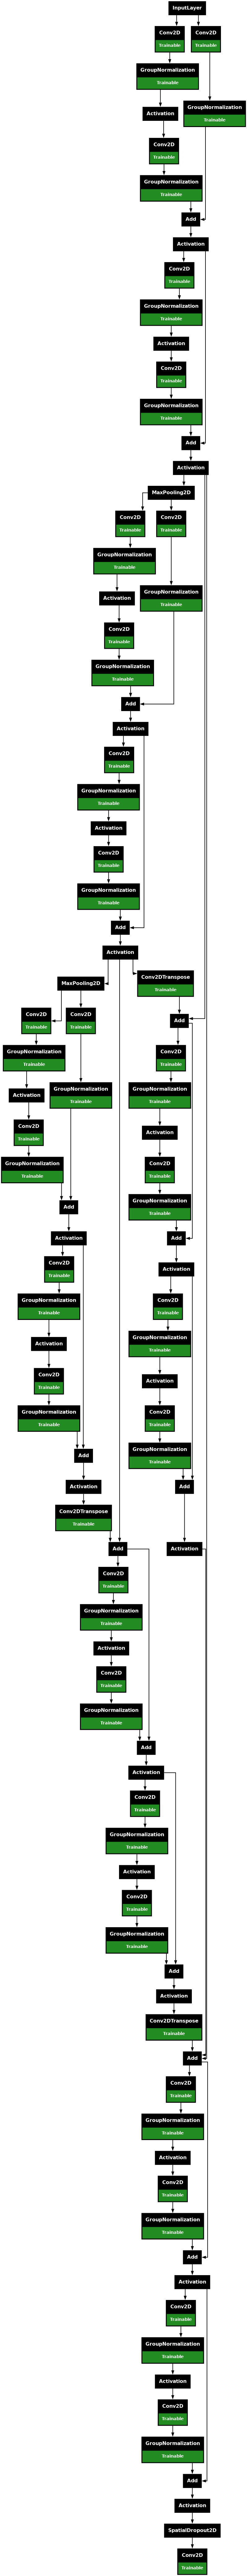

In [20]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

## 🛠️ Train and Save the Model

In [21]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Define a callback class for visualization during training
class VizCallback(tf.keras.callbacks.Callback):

    def __init__(self, image, label):
        super().__init__()
        self.image = image
        self.label = label

    def on_epoch_end(self, epoch, logs=None):
        # Predict using the model and visualize ground truth vs predicted mask
        pred = model.predict(self.image, verbose=0)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (128, 256, 1))
        fig, axes = plt.subplots(1, 2, figsize=(16, 4))
        axes[0].imshow(np.squeeze(self.label))
        axes[0].set_title("Ground Truth Mask")
        colored_image = display_color_mapped_image_continuous(y_pred)
        axes[1].imshow(np.squeeze(colored_image))
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

In [22]:
import tensorflow.keras.backend as K

def _gather_channels(x, indexes, **kwargs):
    """Slice tensor along channels axis by given indexes."""
    backend = kwargs.get('backend', K)
    x = backend.permute_dimensions(x, (3, 0, 1, 2))  # Sposta i canali in prima posizione
    x = backend.gather(x, indexes)  # Seleziona i canali specificati
    x = backend.permute_dimensions(x, (1, 2, 3, 0))  # Riporta i canali all'ultima posizione
    return x

def stable_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    """Numerically stable focal loss for multi-class segmentation, ignoring class 0."""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Checks if y_true is one-hot encoded, otherwise it converts it.
    if len(y_true.shape) < len(y_pred.shape):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])

    # Exclude class 0 selecting channels 1-4
    class_indexes = tf.range(1, 5)  # Indici da 1 a num_classi-1
    y_true = _gather_channels(y_true, indexes=class_indexes, backend=K)
    y_pred = _gather_channels(y_pred, indexes=class_indexes, backend=K)

    # Clipping to avoid numerical unstability.
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

    # Computing of Focal Loss
    loss = -y_true * (alpha * K.pow(1.0 - y_pred, gamma) * K.log(y_pred))

    return K.mean(loss)

Epoch 1/200


I0000 00:00:1734205333.677662      99 service.cc:145] XLA service 0x59b244e76240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734205333.677709      99 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734205333.677713      99 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734205366.498616      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 - 133s - 5s/step - accuracy: 0.2465 - loss: 0.0733 - mean_iou: 0.1519 - val_accuracy: 0.4013 - val_loss: 0.0242 - val_mean_iou: 0.2232 - learning_rate: 4.0000e-04
Epoch 2/200
28/28 - 34s - 1s/step - accuracy: 0.2954 - loss: 0.0344 - mean_iou: 0.1899 - val_accuracy: 0.4493 - val_loss: 0.0186 - val_mean_iou: 0.2479 - learning_rate: 4.0000e-04
Epoch 3/200
28/28 - 33s - 1s/step - accuracy: 0.3271 - loss: 0.0249 - mean_iou: 0.2174 - val_accuracy: 0.4880 - val_loss: 0.0158 - val_mean_iou: 0.2910 - learning_rate: 4.0000e-04
Epoch 4/200
28/28 - 33s - 1s/step - accuracy: 0.3471 - loss: 0.0210 - mean_iou: 0.2370 - val_accuracy: 0.5093 - val_loss: 0.0144 - val_mean_iou: 0.3151 - learning_rate: 4.0000e-04
Epoch 5/200
28/28 - 33s - 1s/step - accuracy: 0.3655 - loss: 0.0188 - mean_iou: 0.2567 - val_accuracy: 0.5209 - val_loss: 0.0132 - val_mean_iou: 0.3326 - learning_rate: 4.0000e-04
Epoch 6/200
28/28 - 33s - 1s/step - accuracy: 0.3791 - loss: 0.0173 - mean_iou: 0.2721 - val_accuracy: 0.5391 -

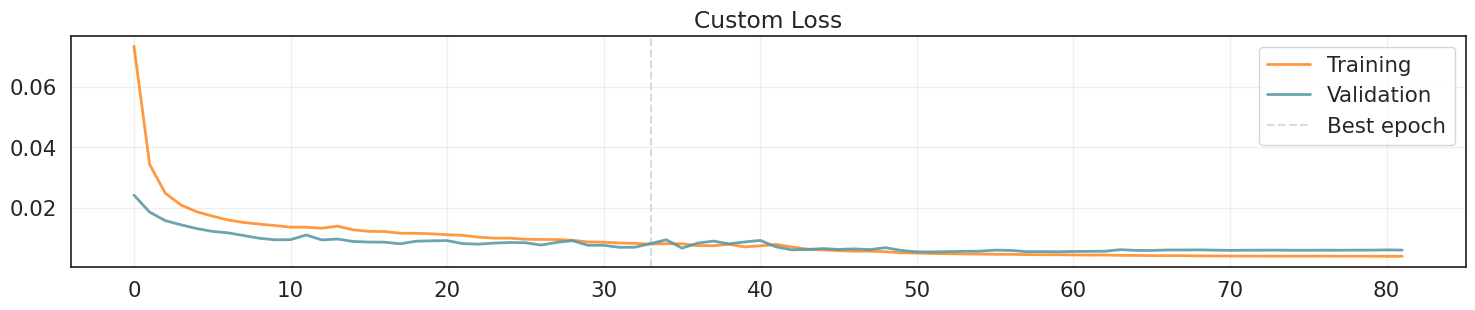

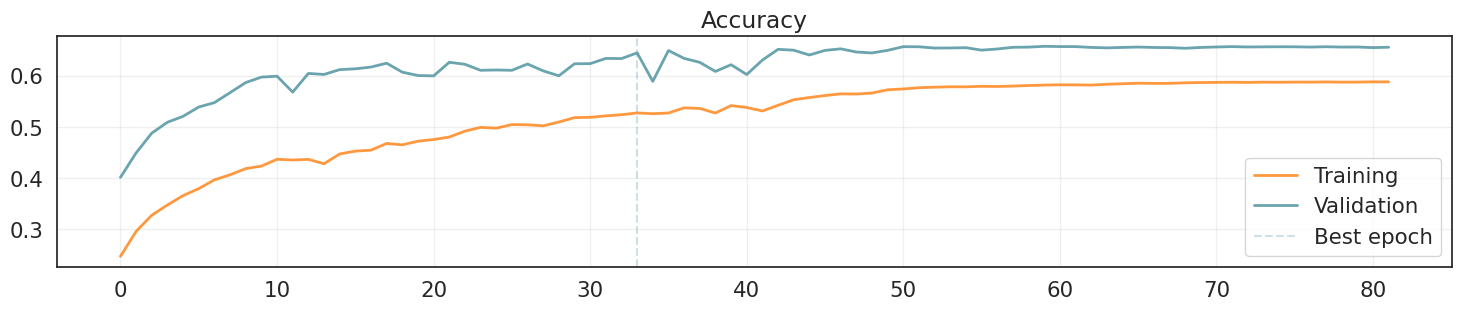

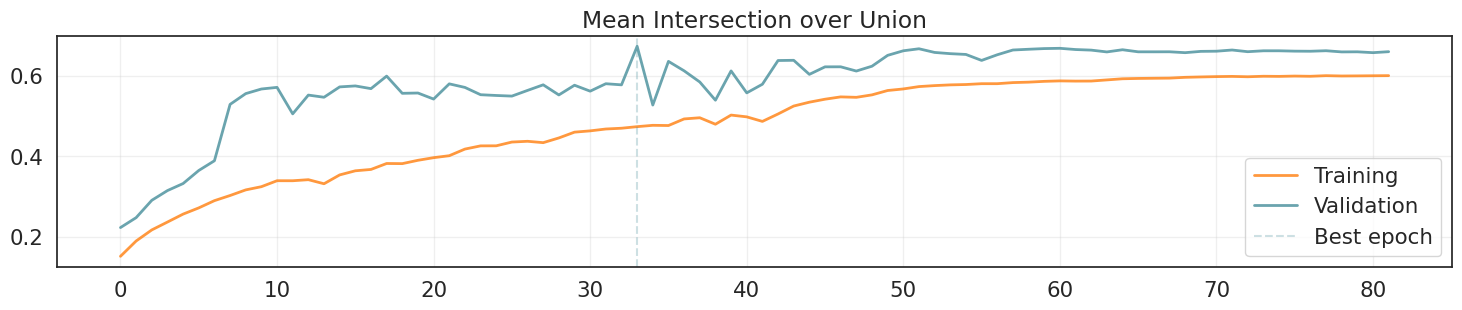

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=4e-4),
    loss=stable_focal_loss,
    metrics=['accuracy', MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)

# Addestramento
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-5)
]

history = model.fit(
    x=X_train*255.0,
    y=y_train,
    validation_data=(X_val*255.0, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=2
)


best_epoch = np.argmax(history.history['val_mean_iou'])
plt.figure(figsize=(18,3))
plt.plot(history.history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Custom Loss')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history.history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history.history['mean_iou'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_mean_iou'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [24]:
print(f"X_test shape: {test_set.shape}")
print(f"y_test shape: {y_test.shape}")

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_set*255.0, y_test, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

X_test shape: (251, 64, 128, 1)
y_test shape: (251, 64, 128)
Test Accuracy: 0.6825
Test Mean Intersection over Union: 0.6276


In [25]:
model_filename = "model_unet_pp.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_silvia.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [26]:
x_test_ev = x_test_ev[..., np.newaxis]

In [27]:
preds = model.predict(x_test_ev)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step
Predictions shape: (10022, 64, 128)


In [28]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [29]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```